# Troublshooting - TensorRT Version Mismatch Issues

##### symptom 1

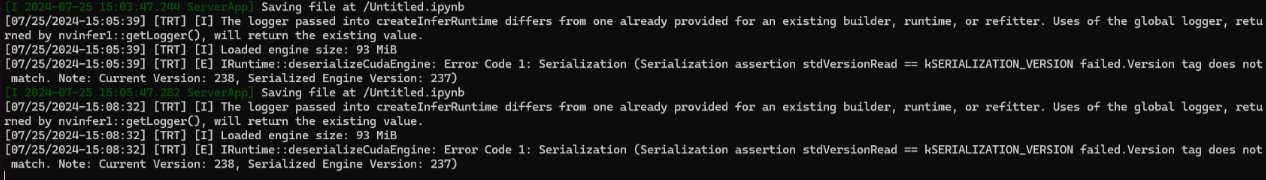

##### symptom 2

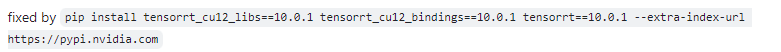

https://github.com/NVIDIA/TensorRT/issues/3838

# Solution - Install the Proper TensorRT version

### Uninstall Other Version

In [29]:
!pip uninstall -y tensorrt_cu12_libs tensorrt_cu12_bindings tensorrtf

Found existing installation: tensorrt-cu12_libs 10.2.0
Uninstalling tensorrt-cu12_libs-10.2.0:
  Successfully uninstalled tensorrt-cu12_libs-10.2.0
Found existing installation: tensorrt-cu12_bindings 10.2.0
Uninstalling tensorrt-cu12_bindings-10.2.0:
  Successfully uninstalled tensorrt-cu12_bindings-10.2.0


You can safely remove it manually.
You can safely remove it manually.


### Install Proper Version

##### versions: https://github.com/nvidia/tensorrt/tags

In [30]:
version = '10.1.0'

In [31]:
!pip install tensorrt_cu12_libs=={version} tensorrt_cu12_bindings=={version} tensorrt=={version} --extra-index-url https://pypi.nvidia.com

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ---------------------------------------- 0.0/1.0 GB ? eta -:--:--
     ---------------------------------------- 0.0/1.0 GB 62.3 MB/s eta 0:00:17
     ---------------------------------------- 0.0/1.0 GB 97.0 MB/s eta 0:00:11
     ---------------------------------------- 0.0/1.0 GB 93.9 MB/s eta 0:00:11
      --------------------------------------- 0.0/1.0 GB 93.9 MB/s eta 0:00:11
      --------------------------------------- 0.0/1.0 GB 93.9 MB/s eta 0:00:11
      --------------------------------------- 0.0/1.0 GB 93.0 MB/s eta 0:00:11
     - -------------------------------------- 0.0/1.0 GB 108.8 MB/s eta 0:00:10
     - -------------------------------------- 0.0/1.0 GB 108.8 MB/s eta 0:00:10
     - -------------------------------------- 0.0/1.0 GB 110.0 MB/s eta 0:00:10
     - -------------------------------------- 0.0/1.0 GB 110.0 MB/s eta 0:00:10
     -- ------------------------------------- 0.1/1.0 GB 129.5 MB/


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### Probably Need to restart iPython Kernel

In [35]:
import tensorrt as trt
trt.__version__

'10.1.0'

---  

# Environment

### Host

In [23]:
!wmic cpu get NumberOfCores,NumberOfLogicalProcessors

NumberOfCores  NumberOfLogicalProcessors  

24             32                         





In [24]:
!systeminfo | findstr "Total"

Total Physical Memory:     65,225 MB


In [25]:
!systeminfo | findstr "OS"

OS Name:                   Microsoft Windows 11 Enterprise
OS Version:                10.0.22631 N/A Build 22631
OS Manufacturer:           Microsoft Corporation
OS Configuration:          Standalone Workstation
OS Build Type:             Multiprocessor Free
BIOS Version:              Dell Inc. 2.15.1, 5/15/2024


### Device

In [3]:
!nvidia-smi

Wed Jul 24 07:55:11 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.85                 Driver Version: 555.85         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX 6000 Ada Gene...  WDDM  |   00000000:01:00.0 Off |                    0 |
| 30%   30C    P2             56W /  300W |     957MiB /  46068MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

---  

# Infer with TensorRT
### The *.trt file was created using Nsight DL Designeer

In [36]:
# !pip install colored matplotlib

In [38]:
import time
import itertools
import numpy as np
from PIL import Image
import tensorrt as trt
trt.__version__

'10.1.0'

### Sample Image

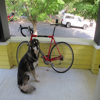

(1, 3, 1200, 1200)

In [2]:
img = Image.open('dog.jpg').resize((1200, 1200))
display(img.resize((100,100)))
img = np.transpose(img, (2, 0, 1))
img = np.array(img).astype(np.float32) / 255.0
img = np.expand_dims(img, axis=0) 
img.shape

### Infer

In [44]:
from polygraphy.backend.trt import TrtRunner
import tensorrt as trt

# load trt file
# The *.trt file was created using Nsight DL Designeer
with open("ssd-10-1.trt", "rb") as f:
    engine_data = f.read()

# create engine
trt_runtime = trt.Runtime(trt.Logger(trt.Logger.VERBOSE))    
engine = trt_runtime.deserialize_cuda_engine(engine_data)

# SOMETHING HERE?
# trt_runtime.??
# engine.??
engine.engine_capability.??

2

In [ ]:
# infer
with TrtRunner(engine) as runner:
    outputs = runner.infer(feed_dict={"image":np.array(img)})

### Output

In [21]:
dict(outputs).keys()

dict_keys(['bboxes', 'labels', 'scores'])

In [22]:
bboxes = outputs["bboxes"][0]
bboxes.shape

(200, 4)

In [23]:
scores = outputs["scores"][0]
scores.shape, scores.max(), scores.min()

((200,), 0.7304468, 0.059816465)

https://gist.githubusercontent.com/aallan/fbdf008cffd1e08a619ad11a02b74fa8/raw/4183a4fd800c2d2d6211fd5129bf88d709072564/coco_labels.txt

### Classes / Labels

In [32]:
labels = outputs["labels"][0]

label_list = []

with open("labels.txt", "r") as f:
    for line in f:
        label_list.extend(line.split())
        
label_dict = {idx: class_name for idx, class_name in enumerate(label_list)}

detected_objects = [(lbl_idx, label_dict[lbl_idx], scr) for lbl_idx, scr in  list(zip(labels, scores))]

detected_objects[:5]

[(2, 'car', 0.7304468),
 (3, 'motorcycle', 0.49776542),
 (8, 'boat', 0.4523836),
 (75, 'laptop', 0.371247),
 (2, 'car', 0.23678857)]

### Visualization


x- 205.59 y- 294.93 w- 736.29 h- 705.27
(2, 'car', 0.7304468)

-------------------------------------



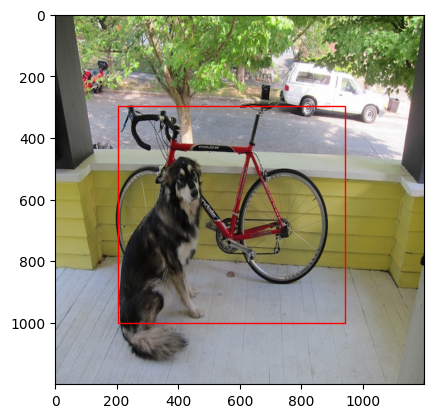

In [34]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


scores = outputs["scores"][0]
bboxes = outputs["bboxes"][0]

MAX_BOXES = 1

fig, ax = plt.subplots()
ax.imshow(Image.open('dog.jpg').resize((1200, 1200)))

for inference_idx, score in enumerate(scores[:MAX_BOXES]):
    
    x1 = [coord * 1200 for coord in bboxes[inference_idx]][0]
    y1 = [coord * 1200 for coord in bboxes[inference_idx]][1]
    
    x2 = [coord * 1200 for coord in bboxes[inference_idx]][2]
    y2 = [coord * 1200 for coord in bboxes[inference_idx]][3]
    
    w = x2-x1
    h = y2-y1

    print("\nx-",round(x1,2),"y-",round(y1,2),"w-",round(w,2),"h-",round(h,2))
    
    rect = patches.Rectangle(xy=(x1,y1), width=w, height=h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
    print(detected_objects[inference_idx])
    print('\n-------------------------------------\n')

plt.show()

In [ ]:
 cuda_libs = '\Users\wihill\AppData\Local\NVIDIA Corporation\NVIDIA Nsight Deep Learning Designer\2024.1.24201.1109 (build 34594487) (public-release)\target\windows-desktop-dl-x64>'

In [83]:
!dir C:\Users\wihill\AppData\Local\NVIDIA 

 Volume in drive C is OS
 Volume Serial Number is 382E-74EB

 Directory of C:\Users\wihill\AppData\Local\NVIDIA

01/12/2024  11:58 AM    <DIR>          .
07/24/2024  03:10 PM    <DIR>          ..
03/06/2024  06:19 PM    <DIR>          DXCache
               0 File(s)              0 bytes
               3 Dir(s)  69,487,714,304 bytes free


[!] Could not find the CUDA runtime library.
    Note: Paths searched were:
    ['C:\\Users\\wihill\\git\\dolphins\\venv\\Scripts', 'C:\\Windows\\system32', 'C:\\Windows', 'C:\\Windows\\System32\\Wbem', 'C:\\Windows\\System32\\WindowsPowerShell\\v1.0\\', 'C:\\Windows\\System32\\OpenSSH\\', 'C:\\Program Files\\dotnet\\', 'C:\\Program Files\\Docker\\Docker\\resources\\bin', 'C:\\Users\\wihill\\AppData\\Local\\Microsoft\\WindowsApps']


PolygraphyException: Could not find the CUDA runtime library.
Note: Paths searched were:
['C:\\Users\\wihill\\git\\dolphins\\venv\\Scripts', 'C:\\Windows\\system32', 'C:\\Windows', 'C:\\Windows\\System32\\Wbem', 'C:\\Windows\\System32\\WindowsPowerShell\\v1.0\\', 'C:\\Windows\\System32\\OpenSSH\\', 'C:\\Program Files\\dotnet\\', 'C:\\Program Files\\Docker\\Docker\\resources\\bin', 'C:\\Users\\wihill\\AppData\\Local\\Microsoft\\WindowsApps']

# NO WORKY STUFF

In [43]:
with open("ssd-10.trt", "rb") as f:
    engine_data = f.read()
engine = trt_runtime.deserialize_cuda_engine(engine_data)
print(engine == None)
context = engine.create_execution_context()

True


AttributeError: 'NoneType' object has no attribute 'create_execution_context'

In [ ]:
inputs, outputs, bindings, stream = _allocate_buffers()

        self.context = self.trt_engine.create_execution_context()
        self.list_output = None